#### Summary: 

In this notebook I look at layer 4 of the classifyer and distinguish three types of neurons (a) by how likely they are to be among the most active neurons in this layer and (b) by how stongly this liklihood varies with changing datsets. Finally I look at how the network's classification acccuracy depends on each class of neurons.  

In [1]:
import numpy as np
import tensorflow as tf
import pickle

from scipy.misc import imrotate

import matplotlib.pyplot as plt 
%matplotlib inline

from functions.build_constant_network import build_network
from functions.multiple_bar_plot import multiple_bar_plot

import random
import copy


PATH = '/home/claudia/Dokumente/Uni/lab_rotation_TU/compare_AER_AEUR'
FIGURES = '/home/claudia/Dokumente/Uni/lab_rotation_TU/compare_AER_AEUR/report/figures/'

from scipy.stats import itemfreq

import seaborn as sns
sns.set()
sns.set_context("paper")

In [2]:
DATA = pickle.load(open(PATH +'/datasets/all_mnist_variants_scipy_rotate.p', 'rb'))

LABELS = DATA['labels']

mnist_neg60 = DATA['mnist_60']
mnist_neg30 = DATA['mnist_neg30']
mnist = DATA['mnist']
mnist_30 = DATA['mnist_30']
mnist_60 = DATA['mnist_60']
mnist_90 = DATA['mnist_90']

mnist_mix = DATA['mnist_mix']

In [3]:
AER_file = PATH + '/network_params/AER_finetuned_params_complete.p'
AER_params = pickle.load(open(AER_file, 'rb'))

W_AER = AER_params['weights_incl_softmax']
B_AER = AER_params['bias_incl_softmax']

x_AER, y_AER, weights_AER, bias_AER, activations_AER, measures_AER = \
build_network(W_AER, B_AER) 

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

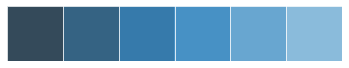

In [4]:
blue = sns.color_palette("Blues_d")
sns.palplot(blue)

#### For each digit we create the high activity pattern (i.e. probability of each neuron to be among the 10% most active neurons)

In [5]:
datasets = ['mnist', 'mnist_neg30', 'mnist_60', 'mnist_mix' ]
layers  = ['h_1', 'h_2', 'h_3', 'h_4']
Weight_tensors = ['W_h2', 'W_h3', 'W_h4', 'W_out']
weights = [1,2,3,4]
sizes = [784, 512, 256, 128]
IDX = DATA['digit_idx']

In [6]:
top10 ={}

for i, lay in enumerate(layers): 
    digit_acts = {}
    
    for h in range(10):    
        activations = np.zeros((4, sizes[i]))
        idx = IDX['only_'+str(h)]
        
        for j,d in enumerate(datasets): 
            N = int(np.ceil(sizes[i]*0.1))
            a = sess.run(activations_AER[lay], feed_dict = {x_AER: DATA[d][idx].T, y_AER: LABELS[idx].T})
            highest_20 = np.argsort(a, axis = 0)[-N:]
            freqs = itemfreq(highest_20)
            
            for k in range(len(freqs)):
                activations[j,freqs[k,0]] = freqs[k,1] / float(len(idx))
                
        digit_acts['digit'+str(h)] = activations
        
    top10[lay] = digit_acts

### Plots of the activity pattern and varainace for a given digit

In [7]:
digit = 1 

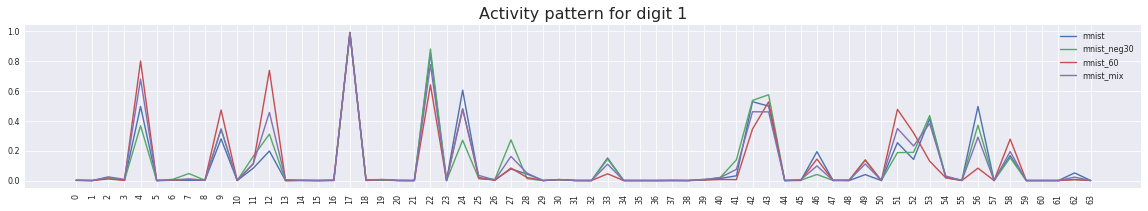

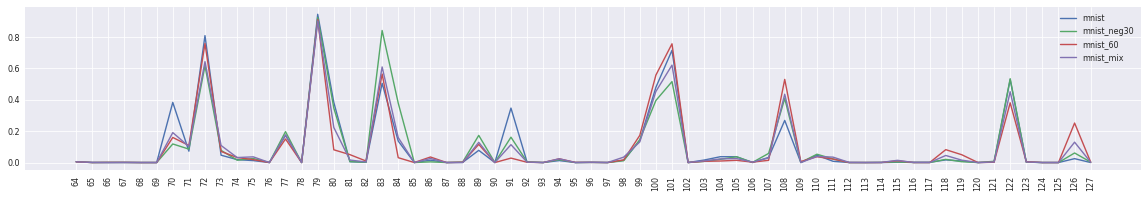

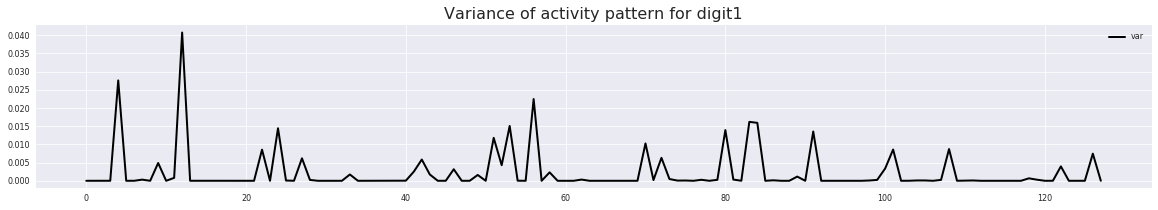

In [8]:
plt.figure(figsize = (20, 3))
for i in range(4):
    plt.plot(top10['h_4']['digit'+str(digit)][i, :64], label = datasets[i] )
plt.legend()
plt.xticks(np.arange(0,64, 1),  rotation = 'vertical')
plt.title('Activity pattern for digit ' + str(digit), size = 16)
plt.show()

plt.figure(figsize = (20, 3))
for i in range(4):
    plt.plot(top10['h_4']['digit'+str(digit)][i, 64:], label = datasets[i] )
plt.legend()
plt.xticks(np.arange(0,64, 1), np.arange(64,128, 1),  rotation = 'vertical')
plt.show()

plt.figure(figsize = (20, 3))
plt.plot(np.var(top10['h_4']['digit'+str(digit)], axis = 0), label = 'var', color = 'k', linewidth = 2)
plt.legend()
plt.title('Variance of activity pattern for digit' + str(digit), size = 16)
plt.show()

In [9]:
#var = np.var(top10['h_4']['digit'+str(digit)], axis = 0)
#scaling_neurons = np.where(var > 0.01)[0]
#M = len(scaling_neurons)
#scaling_neurons


### Define 3 types of neurons:
    -scaling_neurons: they show a high varaince i.e they 'scale' with the dataset
    -invar_neurons_high_activity: neurons that are very likely to be among the most active 10 % but don't vary a lot with the datasest
    -invar_neurons_low_activity: neurons that show low varaibility and alos are unlieky to be among the most active (this will be the largest subgroup)
    

In [10]:
def types_of_neurons(activity_pattern): 
    mean_mean = np.mean(np.mean(activity_pattern, axis = 0))
    mean_std = np.mean(np.sqrt(np.var(activity_pattern, axis = 0)))
    std = np.sqrt(np.var(activity_pattern, axis = 0))
    mean = np.mean(activity_pattern, axis = 0)
    
    
    scaling_neurons = []
    for i in range(128): 
        if std[i] > 5*mean_std: # 5*std is chosen kind of arbitrary but seems to catch most 
                                # intersting cases and the number of neurons found matches the number of
                                # invar neurons with high activity
            scaling_neurons.append(i)

    invar_neurons_high_activity = []
    for i in range(128):
        if mean[i] > mean_mean and std[i] < mean_std: 
            invar_neurons_high_activity.append(i)

    invar_neurons_low_activity = []
    for i in range(128): 
        if mean[i] < mean_mean and std[i] < mean_std: 
            invar_neurons_low_activity.append(i)
            
    return scaling_neurons, invar_neurons_high_activity, invar_neurons_low_activity

#### Plot of the activities mean and standard deviation to get an idea which neurons are chosen for the subgroups

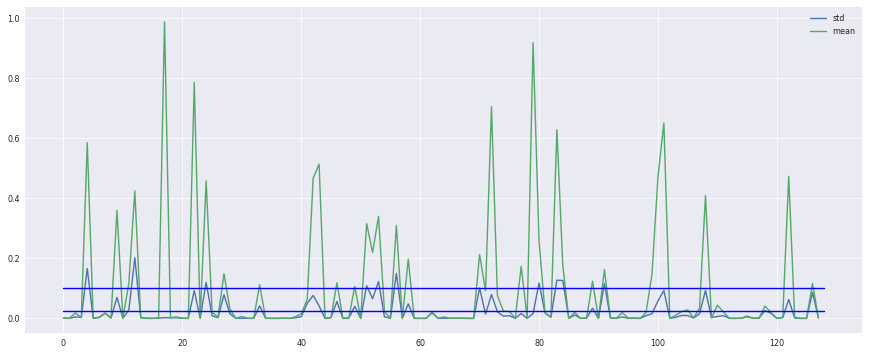

In [16]:
mean_mean = np.mean(np.mean(top10['h_4']['digit'+str(digit)], axis = 0))
mean_std = np.mean(np.sqrt(np.var(top10['h_4']['digit'+str(digit)], axis = 0)))
std = np.sqrt(np.var(top10['h_4']['digit'+str(digit)], axis = 0))
mean = np.mean(top10['h_4']['digit'+str(digit)], axis = 0)


plt.figure(figsize= (15,6))
plt.plot(np.sqrt(np.var(top10['h_4']['digit'+str(digit)], axis = 0)), label = 'std')
plt.plot(np.mean(top10['h_4']['digit'+str(digit)], axis = 0), label = 'mean')
plt.plot([0, 128], [mean_std, mean_std], 'b-')
plt.plot([0, 128], [mean_mean, mean_mean], 'b-')
plt.legend()
plt.show()

### Mean of the scaling neurons across digits 

Find scaling neurons for digit 1 and show mean activity of these neurons for all digits

In [21]:
scaling_neurons, invar_neurons_high_activity, invar_neurons_low_activity = \
                                        types_of_neurons(top10['h_4']['digit'+str(digit)])
M = len(scaling_neurons)

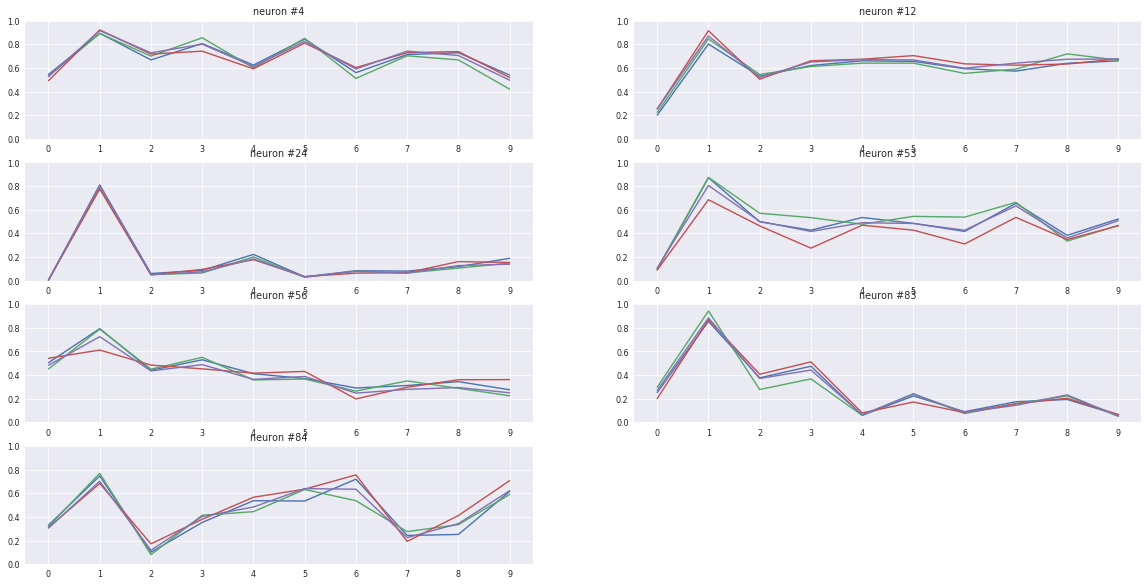

In [24]:
plt.figure(figsize = (20, 10))
for j in range(M):
    plt.subplot(int(np.ceil(M/2.)),2,j+1)
    plt.title('neuron #' + str(scaling_neurons[j]))
    for k, d in enumerate(datasets):
        a = sess.run(activations_AER[lay], feed_dict = {x_AER: DATA[d].T, y_AER: LABELS.T})
        digit_data = np.zeros(10)
        for i in range(10):
            digit_idx = IDX['only_'+str(i)]
            digit_data[i] = np.mean(a[scaling_neurons[j],digit_idx])
        plt.plot(digit_data, label = d)
        plt.xticks(np.arange(0,10, 1))

        plt.ylim(0,1)
    if j == 9: 
        plt.legend()
plt.show()

#### Digitwise effect of switching off each type of neuron 

In [25]:
print('\t \t orig \t\tscaling \t non-scaling_h   non-scaling_l \t dataset: \n')
for k in range(10): 
    idx = IDX['only_'+str(k)]

    sn, in_ha, in_la = types_of_neurons(top10['h_4']['digit'+str(k)])
    
    WW_scale = copy.deepcopy(W_AER)
    WW_scale[4][:, sn] = 0
    
    WW_nonscale1 = copy.deepcopy(W_AER)
    WW_nonscale1[4][:, in_ha] = 0
    
    WW_nonscale2 = copy.deepcopy(W_AER)
    WW_nonscale2[4][:, in_la] = 0
    
    print('# neurons \t\t\t', len(sn),'\t\t', len(in_ha), '\t\t', len(in_la))
    for data in datasets:
        b = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: DATA[data][idx].T, y_AER: LABELS[idx].T})
        c = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: DATA[data][idx].T, y_AER: LABELS[idx].T, \
                                                        weights_AER['W_out']:WW_scale[4]})
        d = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: DATA[data][idx].T, y_AER: LABELS[idx].T, \
                                                        weights_AER['W_out']:WW_nonscale1[4]})
        e = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: DATA[data][idx].T, y_AER: LABELS[idx].T, \
                                                        weights_AER['W_out']:WW_nonscale2[4]})

        print('Digit:', k, '\t', np.round(b, 3),'\t\t', np.round(c, 3), '\t\t', np.round(d, 3), 
              '\t\t', np.round(e, 3), '\t\t', data)

    print('\n')

	 	 orig 		scaling 	 non-scaling_h   non-scaling_l 	 dataset: 

# neurons 			 4 		 5 		 88
Digit: 0 	 0.967 		 0.944 		 0.912 		 0.964 		 mnist
Digit: 0 	 0.962 		 0.939 		 0.907 		 0.962 		 mnist_neg30
Digit: 0 	 0.9 		 0.842 		 0.777 		 0.926 		 mnist_60
Digit: 0 	 0.904 		 0.859 		 0.815 		 0.931 		 mnist_mix


# neurons 			 7 		 4 		 93
Digit: 1 	 0.978 		 0.889 		 0.974 		 1.0 		 mnist
Digit: 1 	 0.981 		 0.911 		 0.977 		 1.0 		 mnist_neg30
Digit: 1 	 0.963 		 0.776 		 0.948 		 1.0 		 mnist_60
Digit: 1 	 0.975 		 0.83 		 0.963 		 1.0 		 mnist_mix


# neurons 			 4 		 6 		 82
Digit: 2 	 0.778 		 0.694 		 0.683 		 1.0 		 mnist
Digit: 2 	 0.7 		 0.573 		 0.57 		 1.0 		 mnist_neg30
Digit: 2 	 0.672 		 0.556 		 0.533 		 1.0 		 mnist_60
Digit: 2 	 0.689 		 0.559 		 0.569 		 1.0 		 mnist_mix


# neurons 			 5 		 5 		 82
Digit: 3 	 0.78 		 0.714 		 0.6 		 0.81 		 mnist
Digit: 3 	 0.877 		 0.843 		 0.75 		 0.958 		 mnist_neg30
Digit: 3 	 0.079 		 0.065 		 0.008 		 0.155 		 mnist_60
Digit:

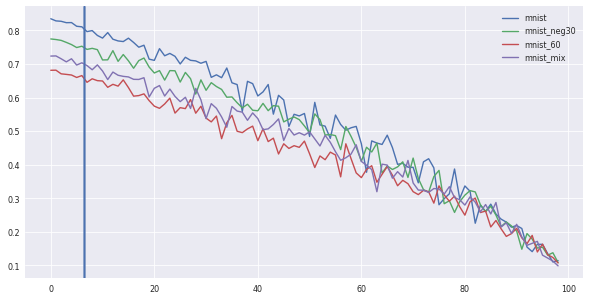

In [26]:
dropout = pickle.load(open(PATH +'/datasets/layerwise_dropout_performance.p', 'rb'))

plt.figure(figsize=(10, 5))
for d in datasets: 
    plt.plot(dropout['W_out'][d], label = d)
    plt.axvline(x=6.5)
plt.legend()
plt.show()

##### Summary: 

for all digits and datasets we see a decrease in accuray when switching off those neurons that show high variance in their response to rotation. Accuracy also decreases if we switch off neurons that show high activity independent of rotation. On the other hand if we switch off those neurons that show low activty and low variance, performance stays the same or even improves even though this last group is gemerally more than ten times larger than the other two. 

### How switching off neurons that are invariant for one digit affects performance for other digits: 

In [30]:
digit = 2

sn, in_ha, in_la = types_of_neurons(top10['h_4']['digit'+str(digit)])

WW_scale = copy.deepcopy(W_AER)
WW_scale[4][:, sn] = 0

WW_nonscale1 = copy.deepcopy(W_AER)
WW_nonscale1[4][:, in_ha] = 0

WW_nonscale2 = copy.deepcopy(W_AER)
WW_nonscale2[4][:, in_la] = 0

print('\t\t orig \t\t scaling \t non_scaling_ha non_scaling_la')
for k in range(10): 
    idx = IDX['only_'+str(k)]


    b = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist[idx].T, y_AER: LABELS[idx].T})
    c = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist[idx].T, y_AER: LABELS[idx].T, \
                                                    weights_AER['W_out']:WW_scale[4]})
    d = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist[idx].T, y_AER: LABELS[idx].T, \
                                                    weights_AER['W_out']:WW_nonscale1[4]})
    
    e = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist[idx].T, y_AER: LABELS[idx].T, \
                                                    weights_AER['W_out']:WW_nonscale2[4]})
    
    print('digit: ', k, '\t', b, '\t', c, '\t', d, '\t', e)

		 orig 		 scaling 	 non_scaling_ha non_scaling_la
digit:  0 	 0.967347 	 0.962245 	 0.984694 	 0.0
digit:  1 	 0.977974 	 0.985022 	 0.977974 	 0.0
digit:  2 	 0.778101 	 0.693798 	 0.68314 	 1.0
digit:  3 	 0.780198 	 0.766337 	 0.764356 	 0.0
digit:  4 	 0.762729 	 0.783096 	 0.762729 	 0.0
digit:  5 	 0.780269 	 0.825112 	 0.720852 	 0.0
digit:  6 	 0.847599 	 0.716075 	 0.762004 	 0.00939457
digit:  7 	 0.810311 	 0.832685 	 0.808366 	 0.0233463
digit:  8 	 0.852156 	 0.889117 	 0.908624 	 0.00513347
digit:  9 	 0.83449 	 0.795837 	 0.850347 	 0.0


##### Summary: 

here we first select the rotation sensitive and insensitive neurons relative for digit 1. We then show the effect of switching off these neurons on the classification accuracy for different digit types of the mnist set. Switching off the rotations sensitive neurons or the in variant neurons wit high activity shows no choerent result (sometimes decreasing, sometimes increasing accuracy). Switching off the invariant neurons with low activity on the other and drastically decreases performance for all digits except one. This makes clear that neurons inactive for one digit code for other digits

##### Questions: 

- should I use more datasets (i.e. more single rotations sets) to get more accurate estimates of variance and mean?
- how should I display the results? I.e. in the previous table, should accuracies be averaged across datasets to show a general tendency to decrease/ inclease?
- Would it be better to look at the percentage of change instead of the actual accuracies?
- Can we conclude that even in layer 4 the digits don't have a completely rotation invariant representation?